<a href="https://colab.research.google.com/github/noshiniy/Deep-Learning-Mini-Project-02/blob/main/Stock_Price_Prediction_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/Deep Learning/Deep Learning Mini Project 02/")
os.getcwd()

'/content/drive/My Drive/Deep Learning/Deep Learning Mini Project 02'

In [82]:
df = pd.read_csv('MSFT_2014Jan-2024Jan.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,37.349998,37.400002,37.099998,37.160000,31.233065,30632200
1,2014-01-03,37.200001,37.220001,36.599998,36.910000,31.022940,31134800
2,2014-01-06,36.849998,36.889999,36.110001,36.130001,30.367346,43603700
3,2014-01-07,36.330002,36.490002,36.209999,36.410000,30.602684,35802800
4,2014-01-08,36.000000,36.139999,35.580002,35.759998,30.056362,59971700
...,...,...,...,...,...,...,...
2511,2023-12-22,373.679993,375.179993,372.709991,374.579987,373.888580,17091100
2512,2023-12-26,375.000000,376.940002,373.500000,374.660004,373.968445,12673100
2513,2023-12-27,373.690002,375.059998,372.809998,374.070007,373.379547,14905400
2514,2023-12-28,375.369995,376.459991,374.160004,375.279999,374.587280,14327000


In [83]:
df = df[['Date', 'Close']]
df

,Date,Close
0,2014-01-02,37.160000
1,2014-01-03,36.910000
2,2014-01-06,36.130001
3,2014-01-07,36.410000
4,2014-01-08,35.759998
...,...,...
2511,2023-12-22,374.579987
2512,2023-12-26,374.660004
2513,2023-12-27,374.070007
2514,2023-12-28,375.279999


In [84]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year = year, month = month, day = day)

In [85]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-85-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2014-01-02
1      2014-01-03
2      2014-01-06
3      2014-01-07
4      2014-01-08
          ...    
2511   2023-12-22
2512   2023-12-26
2513   2023-12-27
2514   2023-12-28
2515   2023-12-29
Name: Date, Length: 2516, dtype: datetime64[ns]

In [86]:
df.index = df.pop('Date')
df

,Close
Date,
2014-01-02,37.160000
2014-01-03,36.910000
2014-01-06,36.130001
2014-01-07,36.410000
2014-01-08,35.759998
...,...
2023-12-22,374.579987
2023-12-26,374.660004
2023-12-27,374.070007


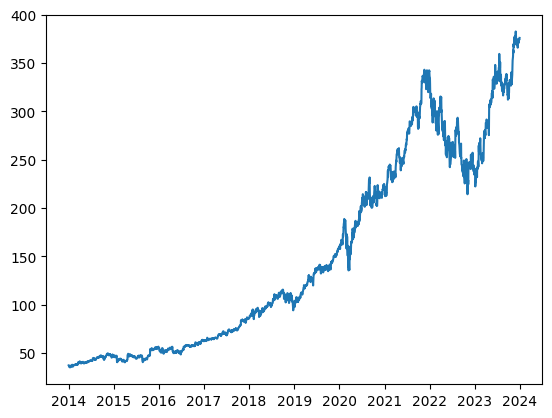

In [87]:
plt.plot(df.index, df['Close'])

In [88]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n = 3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days = 7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day = int(day), month = int(month), year = int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, '2019-01-02', '2023-12-29', n = 3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2019-01-02,101.180000,100.389999,101.570000,101.120003
1,2019-01-03,100.389999,101.570000,101.120003,97.400002
2,2019-01-04,101.570000,101.120003,97.400002,101.930000
3,2019-01-07,101.120003,97.400002,101.930000,102.059998
4,2019-01-08,97.400002,101.930000,102.059998,102.800003
...,...,...,...,...,...
1253,2023-12-22,373.260010,370.619995,373.540009,374.579987
1254,2023-12-26,370.619995,373.540009,374.579987,374.660004
1255,2023-12-27,373.540009,374.579987,374.660004,374.070007
1256,2023-12-28,374.579987,374.660004,374.070007,375.279999


In [89]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1258,), (1258, 3, 1), (1258,))

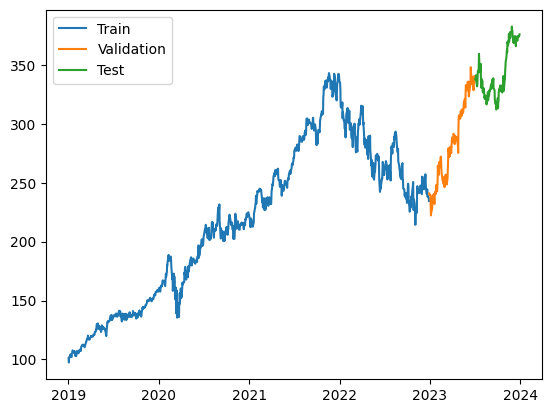

In [90]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(32, activation = 'relu'),
                    layers.Dense(1)])

model.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.001), metrics = ['mean_absolute_error'])

model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

Epoch 1/100
32/32 [==============================] - 4s 23ms/step - loss: 50940.1602 - mean_absolute_error: 216.0536 - val_loss: 80290.5547 - val_mean_absolute_error: 281.2533
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 48965.3594 - mean_absolute_error: 211.3088 - val_loss: 74834.9609 - val_mean_absolute_error: 271.3718
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 39787.9180 - mean_absolute_error: 187.8942 - val_loss: 54110.1172 - val_mean_absolute_error: 229.9713
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 19843.7969 - mean_absolute_error: 122.4517 - val_loss: 20405.5215 - val_mean_absolute_error: 138.5741
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 5783.5078 - mean_absolute_error: 64.0944 - val_loss: 5893.4692 - val_mean_absolute_error: 68.6149
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 3542.7400 - mean_absolute_error: 50.6037 - val_loss: 46

32/32 [==============================] - 0s 2ms/step


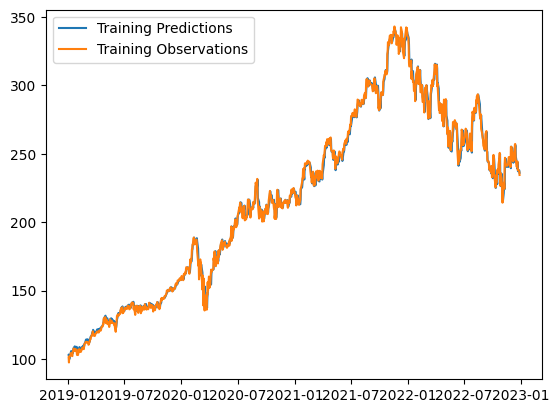

In [92]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

4/4 [==============================] - 0s 3ms/step


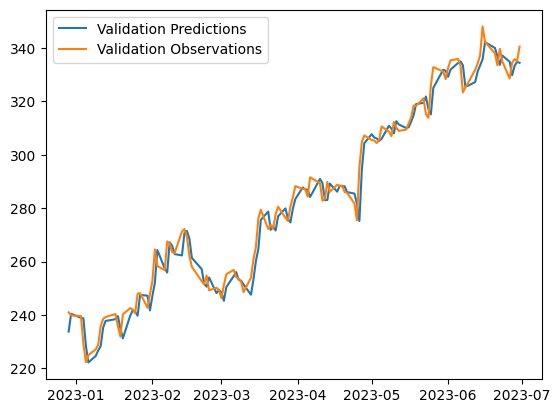

In [93]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

4/4 [==============================] - 0s 3ms/step


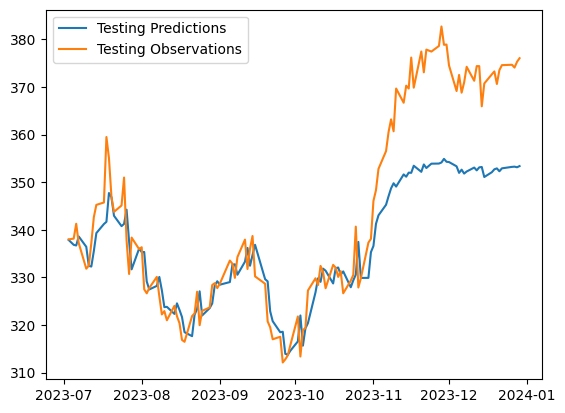

In [94]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

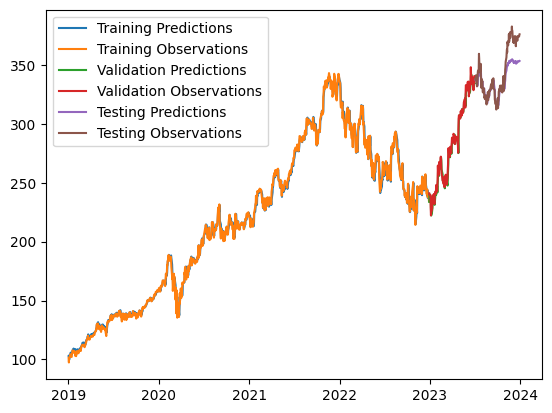

In [95]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [96]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 20ms/step


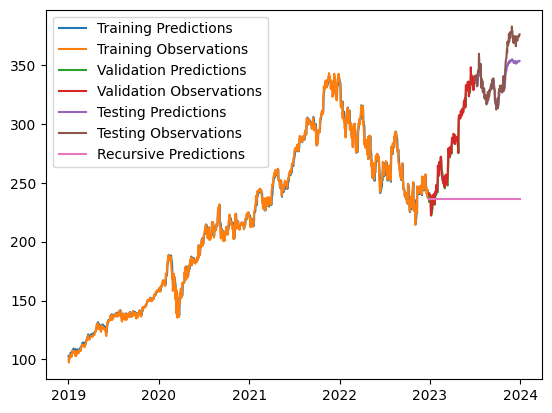

In [97]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])